# 1. Downloading the images
---


Our task is to generate images of dogs, so first we are going to need a lot of dog pictures.

We have chosen to use images from the Google Open Image Dataset V5.

This dataset contains 6 million images of a variety of different objects. Since this dataset is too large for us to download it all, and we only need images of dogs, we are going to filter it first, then download only what we need.





### 1.1 Getting the images from the original source (slow way, skip this step)

In [0]:
!pip install awscli
# Download dataset metadata:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv 
!wget https://datasets.figure-eight.com/figure_eight_datasets/open-images/test-images.csv
# Parsing the dataset download links:
import pandas as pd
descriptions = pd.read_csv(r"class-descriptions-boxable.csv", sep=",", index_col=None, header=None)
dog_id = descriptions.loc[descriptions[1] == 'Dog'].iloc[0][0]
annotations = pd.read_csv(r"test-annotations-bbox.csv", sep=",", index_col=None)
dog_pictures = annotations.loc[annotations['LabelName'] == dog_id]
image_links = pd.read_csv(r"test-images.csv", sep=",", index_col=None)

In [0]:
# Downloading the images: (This takes a looong time..)
!rmdir -rf images_big
!mkdir images_big
import requests
import sys
lastpicture = ""
for id, picture in enumerate(dog_pictures["ImageID"]):
    if picture != lastpicture: 
        filename = "images_big/" + str(id+1) + ".jpg"
        url = image_links.loc[image_links['image_name'] == picture+".jpg"].iloc[0][1]    
        with open(filename, 'wb') as f:
            f.write(requests.get(url).content)
    lastpicture = picture

The downloaded images are of different sizes, so we need to resize them first. We will be using 64x64 images


In [0]:
# Resizing the downloaded images
from PIL import Image
import os, sys
!rm -rf images
!mkdir images
path = "images_big/"
outpath = "images/"
dirs = os.listdir( path )

def resize():
    i = 0
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            imResize = im.resize((64,64), Image.ANTIALIAS)
            imResize.save(outpath + str(i) + '.jpg', 'JPEG', quality=90)
            i+=1
resize()

### 1.2 Getting the dataset from our mirror (recommended)

The above process takes a long time, so we've prepared a ZIP file so we don't have to repeat the above steps.

This file contains 4835 64x64 different images of dogs

In [12]:
!rm -f resized64.zip
!wget https://www.dropbox.com/s/rgetz6d16m1wvap/resized64.zip #64x64
!rm -rf images
!unzip resized64.zip

--2019-12-08 21:33:24--  https://www.dropbox.com/s/rgetz6d16m1wvap/resized64.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rgetz6d16m1wvap/resized64.zip [following]
--2019-12-08 21:33:24--  https://www.dropbox.com/s/raw/rgetz6d16m1wvap/resized64.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7895842433b0d0ae3e7196da7.dl.dropboxusercontent.com/cd/0/inline/AuP1ngv4pv2t7iRPTBo60nvsD3GIKQBleG1wVar-BZV7m_jpSZq_1RrxW1bKImfJWtTPdsai2ZkovM_QoOCuK7omJfvyCNC_6_aArFq9MoiuCX1kpY1eAmzzRi68u3a01SY/file# [following]
--2019-12-08 21:33:25--  https://ucb7895842433b0d0ae3e7196da7.dl.dropboxusercontent.com/cd/0/inline/AuP1ngv4pv2t7iRPTBo60nvsD3GIKQBleG1wVar-BZV7m_jpSZq_1RrxW1bKImfJWtTPdsai2ZkovM_QoOCuK7omJfvyCNC_6_aArFq9Moiu

# 2. Training data visualization

---


Let us take a look at the images:

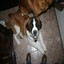

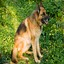

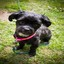

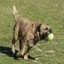

In [15]:
from IPython.display import Image
from IPython.display import display
display(Image('images/1.jpg'))
display(Image('images/2.jpg'))
display(Image('images/123.jpg'))
display(Image('images/321.jpg'))

# 3. Preparing the data

---

Now we need to transform the image to a form we can feed into a neural network


In [0]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os
x_list = []
for filename in os.listdir("images/"):
  # Loading each image into an array
  img = np.asarray(image.load_img("images/"+filename))
  x_list.append(img)
x_train = np.asarray(x_list)

# Transforming data values from (0, 255) to (-1, 1):
x_train = x_train / 127.5 - 1

In [17]:
print(x_train.shape) # The training dataset contains 4835 images with the size of 64x64 each having 3 color channels.

(4835, 64, 64, 3)


# 4. Constructing the network


---

Original network from:

https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [18]:
!pip install SpectralNormalizationKeras

ERROR: Could not find a version that satisfies the requirement SpectralNormalizationKeras (from versions: none)
ERROR: No matching distribution found for SpectralNormalizationKeras


In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,Conv2D,MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np


In [0]:
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.00002
batch_size = 16
np.random.seed(69)

class GAN():

  # Building the discriminator network
  def build_discriminator(self):
    model = Sequential()
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), input_shape = self.img_shape)) 
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))  
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(),kernel_initializer='glorot_uniform'))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) 
    
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  # Building the generator network
  def build_generator(self):
   
    model = Sequential()
    model.add(Dense(8*8*512, kernel_initializer='glorot_uniform' , input_dim = self.latent_dim))
    model.add(Reshape((8,8,512)))
    model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(128, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(Conv2D(32, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(16, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(Conv2D(16, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    
    model.add(Conv2D(8, kernel_size=4, strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform')) 
    model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM))
    model.add(Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh'))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  
  def __init__(self):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    # Setting latent dimension size
    self.latent_dim = 80    
    optimizer = Adam(0.0005, 0.5)

    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])

    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)

  


In [21]:
# Creating the GAN network
gan = GAN()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 31, 128)       73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 31, 31, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [0]:
# discriminator outputs
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0




In [0]:
# drawing generated images

from IPython import display

def plot_images(gan, step):
  r, c = 2,2
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # scaling: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  print(gen_imgs.shape)
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt])
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 loss_D 0.7006812 loss_G 0.7057464
(4, 64, 64, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


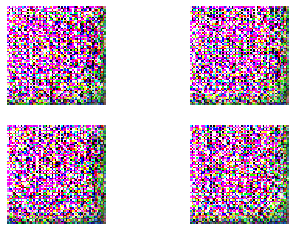

100 loss_D 0.5816053 loss_G 1.5143876
(4, 64, 64, 3)


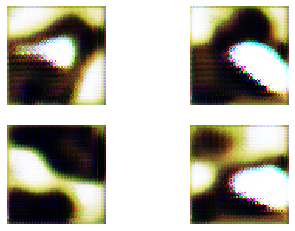

200 loss_D 0.45692903 loss_G 1.2788187
(4, 64, 64, 3)


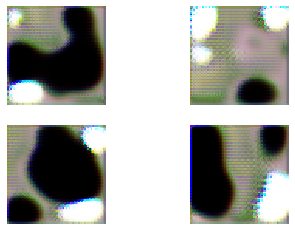

300 loss_D 0.3783853 loss_G 2.1796734
(4, 64, 64, 3)


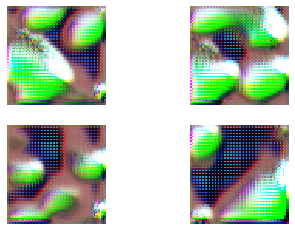

400 loss_D 0.17140666 loss_G 3.7473922
(4, 64, 64, 3)


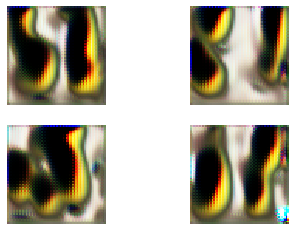

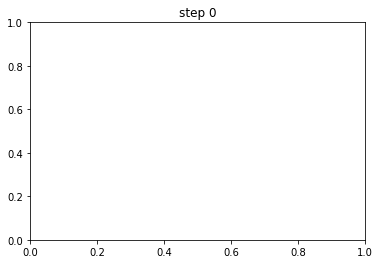

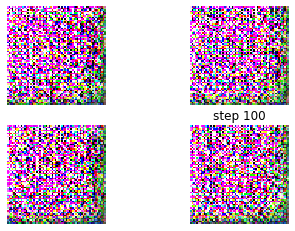

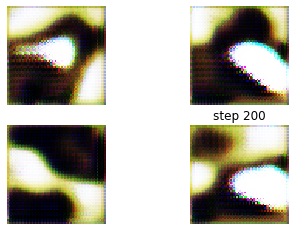

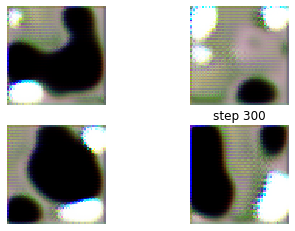

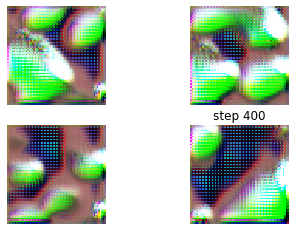

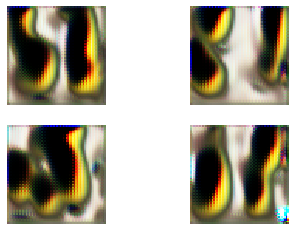

In [24]:
# Training Generator and Discriminator and visualizing outputs

i = 0
for step in range(500):
    
  # selecting randomly images for a batch
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  
  
  # generating a batch of images
  noise = np.random.normal(0, 0.6, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # training generator network
  g_loss = gan.combined.train_on_batch(noise, valid)

  # training discriminator
  #if i%3 == 0:
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  # log
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    
  # drawing generated images
  if step % 100 == 0:
    plot_images(gan, step)
    

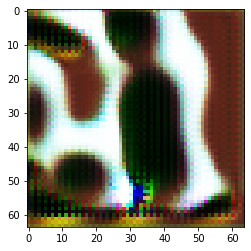

In [25]:
# Generating then drawing an image
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
gen_img = 0.5 * gen_img + 0.5
plt.imshow(gen_img.reshape(64,64,3))